In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os import path
import sys, inspect
current_dir = path.dirname(path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from nu_aesthetics.single_colors import brand, design
from nu_aesthetics.palettes import sequential, discrete, matplot
from matplotlib.cm import register_cmap
register_cmap("discrete_NU_PPT", discrete.NU_PPT)


from support.shared_consts import *
from support.utils import *

/home/jovyan/.conda/envs/cs-lusa-v7/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The palettes.matplot module is deprecated. Please use palettes.sequential or palettes.legacy instead
  app.launch_new_instance()
/home/jovyan/.conda/envs/cs-lusa-v7/lib/python3.6/site-packages/nu_aesthetics/utils/cb_unsafe_warning.py:41: UserWarning: Palette COLORFUL_V6 is not colorblind safe
  warnings.warn(f"Palette {attr:s} is not colorblind safe")
/home/jovyan/.conda/envs/cs-lusa-v7/lib/python3.6/site-packages/nu_aesthetics/utils/cb_unsafe_warning.py:41: UserWarning: Palette SIMPLE_V6 is not colorblind safe
  warnings.warn(f"Palette {attr:s} is not colorblind safe")


# Model

$Y = \beta_0 + \beta_1 x_1 + \dots + \beta_k x_k + \epsilon$

## Canonical X

Intercept    7.680093
x            1.288105
dtype: float64


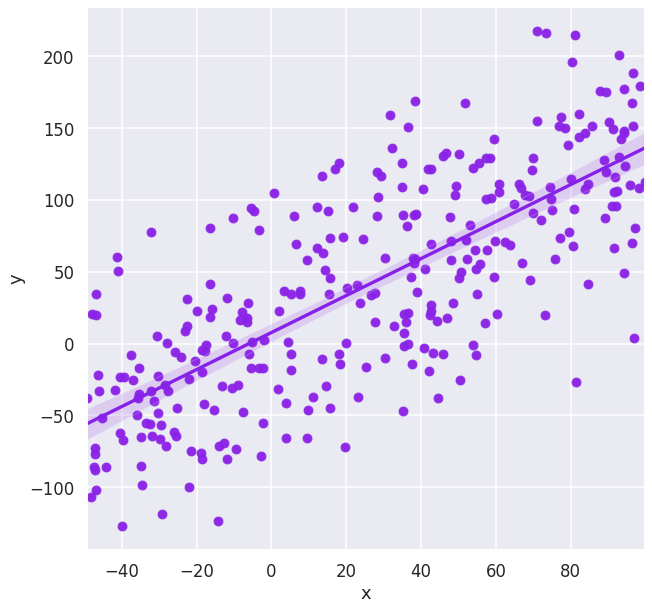

In [3]:
x = x_fix.copy()
e = e_fix.copy()
y = y_fix.copy()
data = pd.DataFrame({"x": x, "e": e, "y": y})

regressor = smf.ols(formula="y ~ x", data=data).fit()
print(regressor.params)

with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.scatterplot(x="x", y="y", data=data, color=brand.NU_LIGHT_PURPLE_MATPLOT)
    sns.regplot(x="x", y="y", data=data, color=brand.NU_BRIGHT_PURPLE_MATPLOT)
    plt.show()

## Bias

Suppose the true model is $Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2$ but you fit the model $Y = \beta^{'}_0 + \beta^{'}_1 x_1$. Then $\beta^{'}_1 = \beta_1 + \beta_2 \frac{\sigma_{X_1 X_2}}{\sigma^2_{X_2}}$, where $\sigma_{x_1 x_2}$ is the covariance of $X_1$ and $X_2$.<br/>

If $X_1$ and $X_2$ are orthogonal, there is no problem in your model.  
If $X_1$ and $X_2$ are correlated but the variance of $X_2$ dominates the covariance, your model is adequate.  
If $X_1$ and $X_2$ are correlated, your model is biased when $X_2$ is a relevant variable ($\beta_2 \neq 0$). Notice that the bias does not depend on the direction of the correlation.  

## Correlation remedies

- collect data to remove or reduce it
- use ridge-regression
- incorporate (and test) a prori knowledge. Example:
$Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2$, with $X_1$ and $X_2$ correlated. You suspect that $b_1 = b_2 = b_{*}$; then you could also fit the model $Y = \beta_0 + \beta_{*} (x_1 + x_2)$ and contrast both models to test if $\beta_1 = \beta_2$.

**Uncorrelated omitted variable**

Intercept   -12.915210
x             1.206956
dtype: float64
Intercept     53.199300
x              1.290014
z           -102.351885
dtype: float64


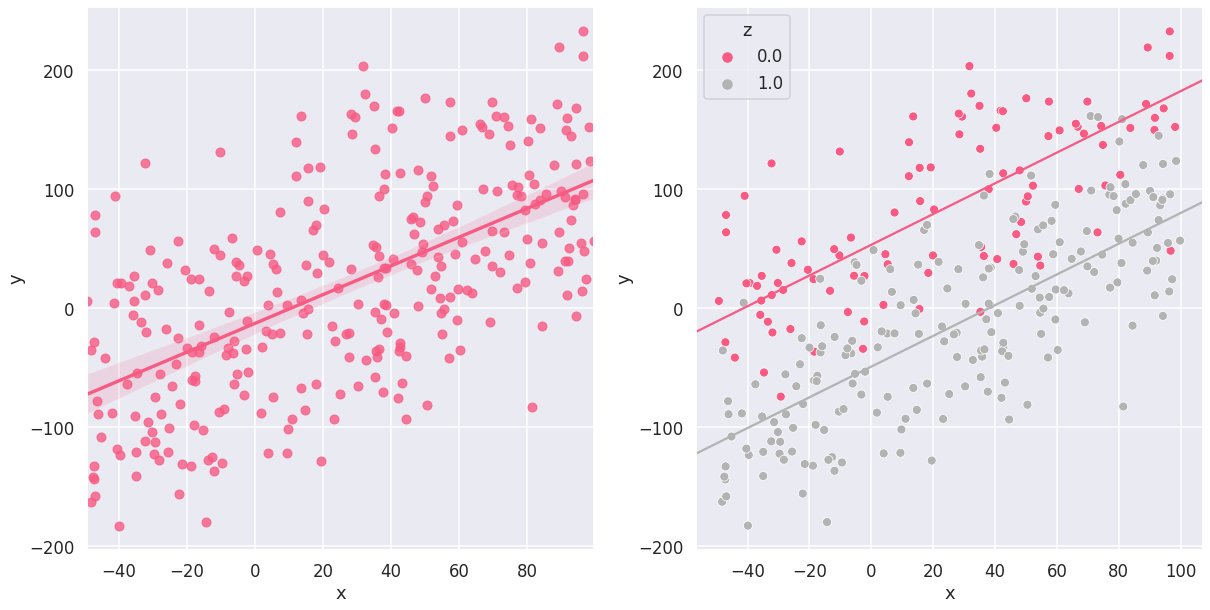

In [4]:
x = x_fix.copy()
e = e_fix.copy()
y = np.zeros(n)
y[:n//3] = +50 + true_params["b1"] * x[:n//3] + e[:n//3]
y[n//3:] = -50 + true_params["b1"] * x[n//3:] + e[n//3:]
data = pd.DataFrame({"x": x,
                     "e": e,
                     "y": y})
data.loc[:n//3, "z"] = 0
data.loc[n//3:, "z"] = 1

regressor = smf.ols(formula="y ~ x", data=data).fit()
print(regressor.params)
regressor = smf.ols(formula="y ~ x + z", data=data).fit()
print(regressor.params)

with sns.plotting_context("talk"), sns.color_palette("discrete_NU_PPT"):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    sns.regplot(x="x", y="y", data=data, ax=ax[0])
    sns.scatterplot(x="x", y="y", hue="z", data=data, ax=ax[1])
    ax[1].axline((0, regressor.params["Intercept"]), slope=regressor.params["x"], color=f"C{0}")
    ax[1].axline((0, regressor.params["Intercept"] + regressor.params["z"]), slope=regressor.params["x"], color=f"C{1}")
    plt.savefig(f"../imgs/simul_uncorr_omitted_var.png", bbox_inches="tight")
    plt.show()

## Confounding

Intercept    7.824751
x            0.394433
dtype: float64
Intercept    48.471329
x             1.222718
z           -92.683301
dtype: float64


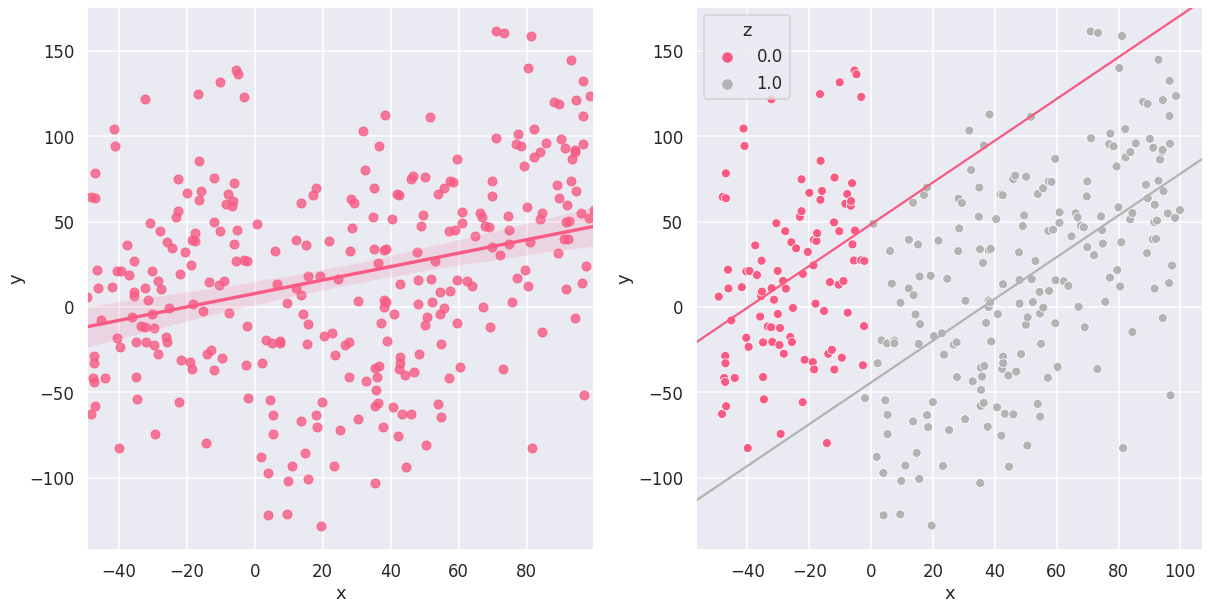

In [5]:
x = x_fix.copy()
e = e_fix.copy()
np.random.seed(seed)
idx = np.arange(n)
np.random.seed(seed)
data = pd.DataFrame({"x": x,
                     "e": e})\
    .sort_values("x", ascending=True).reset_index()
data["y"] = 0
data.loc[:n//3, "y"] = +50 + true_params["b1"] * data.loc[:n//3, "x"] + data.loc[:n//3, "e"]
data.loc[:n//3, "z"] = 0
data.loc[n//3:, "y"] = -50 + true_params["b1"] * data.loc[n//3:, "x"] + data.loc[n//3:, "e"]
data.loc[n//3:, "z"] = 1

regressor = smf.ols(formula="y ~ x", data=data).fit()
print(regressor.params)
regressor = smf.ols(formula="y ~ x + z", data=data).fit()
print(regressor.params)

with sns.plotting_context("talk"), sns.color_palette("discrete_NU_PPT"):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    sns.regplot(x="x", y="y", data=data, ax=ax[0])
    sns.scatterplot(x="x", y="y", hue="z", data=data, ax=ax[1])
    ax[1].axline((0, regressor.params["Intercept"]), slope=regressor.params["x"], color=f"C{0}")
    ax[1].axline((0, regressor.params["Intercept"] + regressor.params["z"]), slope=regressor.params["x"], color=f"C{1}")
    plt.savefig(f"../imgs/simul_confound.png", bbox_inches="tight")
    plt.show()

Intercept   -4.464566
x            2.181778
dtype: float64
Intercept    -51.528671
x              1.222718
z            107.316699
dtype: float64


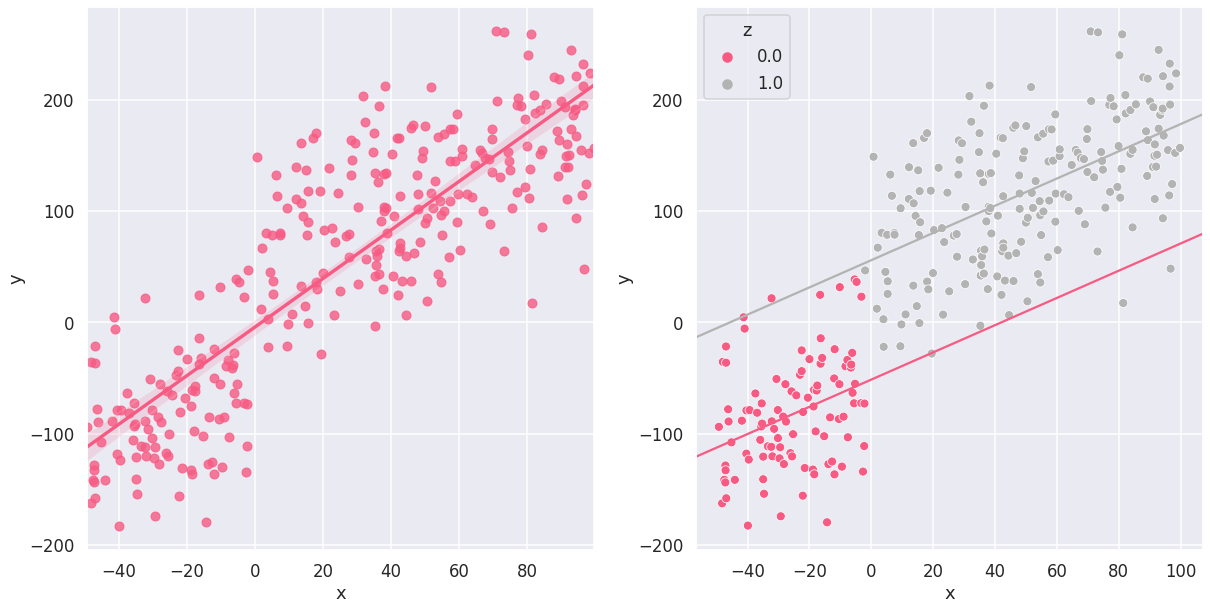

In [6]:
x = x_fix.copy()
e = e_fix.copy()
np.random.seed(seed)
idx = np.arange(n)
np.random.seed(seed)
data = pd.DataFrame({"x": x,
                     "e": e})\
    .sort_values("x", ascending=True).reset_index()
data["y"] = 0
data.loc[:n//3, "y"] = -50 + true_params["b1"] * data.loc[:n//3, "x"] + data.loc[:n//3, "e"]
data.loc[:n//3, "z"] = 0
data.loc[n//3:, "y"] = +50 + true_params["b1"] * data.loc[n//3:, "x"] + data.loc[n//3:, "e"]
data.loc[n//3:, "z"] = 1

regressor = smf.ols(formula="y ~ x", data=data).fit()
print(regressor.params)
regressor = smf.ols(formula="y ~ x + z", data=data).fit()
print(regressor.params)

with sns.plotting_context("talk"), sns.color_palette("discrete_NU_PPT"):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    sns.regplot(x="x", y="y", data=data, ax=ax[0])
    sns.scatterplot(x="x", y="y", hue="z", data=data, ax=ax[1])
    ax[1].axline((0, regressor.params["Intercept"]), slope=regressor.params["x"], color=f"C{0}")
    ax[1].axline((0, regressor.params["Intercept"] + regressor.params["z"]), slope=regressor.params["x"], color=f"C{1}")
    plt.show()